# <center> Homework 2: Gaussian Mixture Model (GMM) </center>
<div>
    <center> RAZAFINDRAZAKA Henintsoa </center>
    <center> WANG James </center>
    <center> ____________</center>
    <center> ING5 SI GR02 </center>
    <center> 16/10/2020 </center>
</div>

# <center> [Task] </center>


> Implement yourself the GMM algorithm for Example 1 (density estimation for a Gaussian mixture) given in the Lab 2 document, but now in 3 dimensions (instead of 2 dimensions, which was the case in Example 1).


## 1. Imports

### 1. Lab example

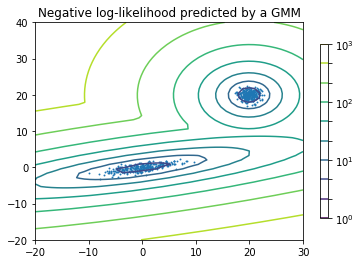

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(X_train[:, 0], X_train[:, 1], .8)
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

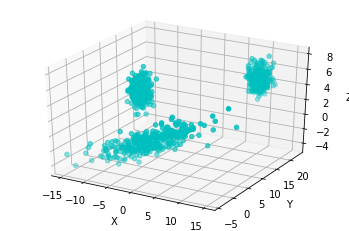

In [595]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (10, 20, 5)
shifted_gaussian = np.random.randn(n_samples, 3) + np.array([10, 20, 5])

# generate zero centered stretched Gaussian data
C1 = np.array([[0., -0.7, 1], [3.5, .7, 1], [3.5, .7, 1]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 3), C1)

# generate spherical data centered on (-5, 5, 5)
shifted_gaussian2 = np.random.randn(n_samples, 3) + np.array([-5, 5, 5])

# concatenate the three datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian, shifted_gaussian2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='c', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


### 1. Initialization

In [604]:
# number of clusters 
J = 3

# Dimension of the data
N = X_train.shape[1]
I = X_train.shape[0]

phi = np.full((J,), 1/J)

µ = np.zeros((N,J))
for n in range(N):
    for j in range(J):
        µ[n][j] = np.sum(X_train[:,n])/n_samples + np.random.rand()*2
        
# Covariance matrix
cov = np.zeros((J,N,N))
for j in range(J):
    for n in range(N):
        cov[j][n][n] = np.random.rand()*10

theta = [phi, µ, cov]


### 2. EM algorithm

##### 2.1 E-step

In [605]:
W = np.zeros((X_train.shape[0], J))


In [616]:

for i in range(I):
    for j in range(J):
        X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
        expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
        Wnum = ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[j])**(1/2)) ) * expo * phi[j]
        Wdenom = 0
        for k in range(J):
            X_µ = (X_train[i] - µ[:,k]).reshape(N,1)
            expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
            Wdenom +=  ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[k])**(1/2)) ) * expo * phi[k]

        W[i][j] = Wnum / Wdenom

W

array([[3.20467101e-28, 9.99989302e-01, 5.71478933e-02],
       [2.87214554e-34, 9.99956596e-01, 6.36208833e-01],
       [2.36279703e-28, 9.99930604e-01, 1.58076767e-01],
       ...,
       [1.00000000e+00, 8.15925508e-01, 2.74999493e-06],
       [1.00000000e+00, 9.99971225e-01, 1.53914619e-06],
       [9.99999208e-01, 9.99997803e-01, 5.12880896e-06]])

##### 2.2 M-step : 
##### Model Parameters θ = (ϕ,µ,Σ) update 

In [615]:
# Update of phi

for j in range(J):
    phi[j] = W[:,j].sum() / I

    
# Update of µ

for j in range(J):
    num = np.zeros((X_train[0].shape))
    denom = W[:,j].sum()
    for i in range(I):
        num += W[i][j] * X_train[i]
        
    µ[:,j] = num / denom

    
# Update of cov (= sigma)

for j in range(J):
    num = np.zeros(cov[0].shape)
    denom = W[:,j].sum()
    
    for i in range(I):
        X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
        num += W[i][j] * X_µ.dot( X_µ.T  ) 
    cov[j] = num / denom



In [282]:
def E_step(data, params, distribution_Z, n_clusters):
    J = n_clusters
    X_train = data
    # Dimensions of the data
    I , N = X_train.shape[0] , X_train.shape[1]
    
    [phi, µ, cov] = params
    
    W = distribution_Z
    
    for i in range(I):
        for j in range(J):
            X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
            expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
            Wnum = ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[j])**(1/2)) ) * expo * phi[j]
            Wdenom = 0
            for k in range(J):
                X_µ = (X_train[i] - µ[:,k]).reshape(N,1)
                expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
                Wdenom +=  ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[k])**(1/2)) ) * expo * phi[k]

            W[i][j] = Wnum / Wdenom
    
    distribution_Z = W

In [285]:
def M_step(data, params, distribution_Z, n_clusters):
    J = n_clusters
    X_train = data
    # Dimensions of the data
    I , N = X_train.shape[0] , X_train.shape[1]
    
    [phi, µ, cov] = params
    
    W = distribution_Z
    
    # Update of phi
    for j in range(J):
        phi[j] = W[:,j].sum() / I

    # Update of µ
    for j in range(J):
        num = np.zeros((X_train[0].shape))
        denom = W[:,j].sum()
        
        for i in range(I):
            num += W[i][j] * X_train[i]
        µ[:,j] = num / denom

    # Update of cov (= sigma)
    for j in range(J):
        num = np.zeros(cov[0].shape)
        denom = W[:,j].sum()

        for i in range(I):
            X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
            num += W[i][j] * X_µ.dot( X_µ.T  ) 
        cov[j] = num / denom

    params = [phi, µ, cov]

In [343]:
def Gaussian_Mixture_Model(data , n_clusters, e):
    J = n_clusters
    X_train = data
    # Dimensions of the data
    I , N = X_train.shape[0] , X_train.shape[1]

    #################### Model Parameters initialization ####################
    # phi init
    phi = np.full((J,), 1/J)

    # µ init
    µ = np.zeros((N,J))
    for n in range(N):
        for j in range(J):
            µ[n][j] = np.sum(X_train[:,n])/n_samples + np.random.rand()*2

    # Covariance matrix init
    cov = np.zeros((J,N,N))
    for j in range(J):
        for n in range(N):
            cov[j][n][n] = np.random.rand()*10
            
    theta = [phi, µ, cov]
    
    # Initialization of the probability distribution of Z
    W = np.zeros((I,J))

    #################### Repeat EM algo until convergence ####################
    marginal_likelihood = [0,100]
    OLD, NEW = 0, 1
    epochs = 0
        
    while np.abs(marginal_likelihood[NEW] - marginal_likelihood[OLD]) > e:
        epochs += 1
        marginal_likelihood[OLD] = marginal_likelihood[NEW]
        marginal_likelihood[NEW] = 0
        
        E_step(X_train, theta, W, J)
        M_step(X_train, theta, W, J)
        
        # Calculation of the new marginal likelihood
        for i in range(I):
            P_X = 0
            for k in range(J):
                X_µ = (X_train[i] - µ[:,k]).reshape(N,1)
                expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
                P_X +=  ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[k])**(1/2)) ) * expo * phi[k]

            marginal_likelihood[NEW] += np.log(P_X)
    
    print("nb of epochs : ", epochs)
    
    return np.round(W)
    

In [345]:
Gaussian_Mixture_Model(X_train, J, 0.001)


C:\Users\henin\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


nb of epochs :  8


C:\Users\henin\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


array([[nan,  1.,  0.],
       [nan,  1.,  0.],
       [nan,  1.,  0.],
       ...,
       [nan,  0.,  0.],
       [nan,  0.,  0.],
       [nan,  0.,  0.]])

In [310]:
e = 0.001

J = 3 # n_clusters
# X_train = data
# Dimensions of the data
I , N = X_train.shape[0] , X_train.shape[1]

#################### Model Parameters initialization ####################
# phi init
phi = np.full((J,), 1/J)

# µ init
µ = np.zeros((N,J))
for n in range(N):
    for j in range(J):
        µ[n][j] = np.sum(X_train[:,n])/n_samples + np.random.rand()*2

# Covariance matrix init
cov = np.zeros((J,N,N))
for j in range(J):
    for n in range(N):
        cov[j][n][n] = np.random.rand()*10

theta = [phi, µ, cov]

# Initialization of the probability distribution of Z
W = np.zeros((I,J))


In [311]:
#################### Repeat EM algo until convergence ####################
marginal_likelihood = [0,100]
OLD, NEW = 0, 1
epochs = 0

while np.abs(marginal_likelihood[NEW] - marginal_likelihood[OLD]) > e:
    epochs += 1
    marginal_likelihood[OLD] = marginal_likelihood[NEW]
    marginal_likelihood[NEW] = 0

    E_step(X_train, theta, W, J)
    M_step(X_train, theta, W, J)

    # Calculation of the new marginal likelihood
    for i in range(I):
        P_X = 0
        for k in range(J):
            X_µ = (X_train[i] - µ[:,k]).reshape(N,1)
            expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
            P_X +=  ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[k])**(1/2)) ) * expo * phi[k]

        marginal_likelihood[NEW] += np.log(P_X)

print("nb of epochs : ", epochs)

print(np.round(W))

nb of epochs :  109
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


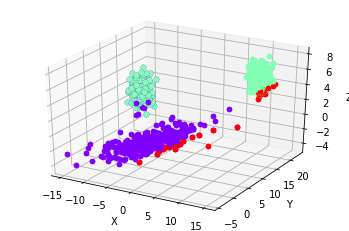

In [617]:
import matplotlib.cm as cm

# Associating the target cluster to each data

labeled_data = []
for j in range(J):
    labeled_data.append([])
    
for i in range(I):
    for j in range(J):
        if np.round(W[i][j]) == 1:
            labeled_data[j].append(X_train[i])


# Displaying the data labeled with a color
colors = cm.rainbow(np.linspace(0, 1, J))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for clusters, c in zip(labeled_data, colors):
    for x in clusters:
        ax.scatter(x[0], x[1], x[2] , color=c)
        ax.scatter(x[0], x[1], x[2] , color=c)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()



1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

0.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

0.0 

1.0 

1.0 

1.0 

1.0 

1.0 

0.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

1.0 

0.0 

1.0 

1.0 

### 3. Label prediction